# Sparse Regression Test

In [3]:
import pandas as pd
import numpy as np
import scipy
import gc
import random

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import pystan
import pickle
from pystan import StanModel

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from orbit.diagnostics.metrics import mse
from orbit.diagnostics.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_trend, make_seasonality, make_regression

In [17]:
NUM_OF_REGRESSORS = 50
SERIES_LEN = 300
SEED = 6868
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(0.1, 0.5, NUM_OF_REGRESSORS)
SIGNS = np.random.default_rng(SEED).choice([1, -1], NUM_OF_REGRESSORS)
COEFS = COEFS * SIGNS

In [18]:
x, y, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS, relevance=0.2, sparsity=0.2)
print(y.shape, x.shape)

(300,) (300, 50)


In [19]:
coefs

array([ 0.        ,  0.30395102,  0.        ,  0.        ,  0.        ,
        0.4864026 ,  0.46874028, -0.4867138 ,  0.        ,  0.        ,
        0.4327999 ,  0.        ,  0.        , -0.47003736,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.1735413 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.13289005,  0.41106304,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.31965908])

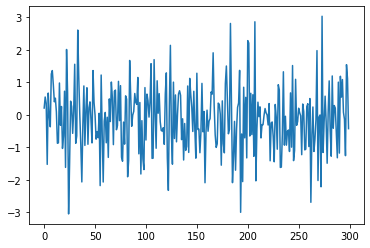

In [20]:
plt.plot(y);

# Laplace Prior [Stan]

In [21]:
input_data = {
    'N': SERIES_LEN,
    'P': x.shape[1],
    'X': x.transpose(),
    'y': y,
}

In [8]:
# first time / refresh
lp_stan_code = """
data {
  int<lower=1> N; // Number of data
  int<lower=1> P; // Number of predictors/covariates
  matrix[P, N] X;
  real y[N];
}

parameters {
  vector[P] beta;
  real alpha;
  real<lower=0> sigma;
}

model {
  // Strongly regularizing priors
  beta ~ double_exponential(0, 1);
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 2);

  y ~ normal(X' * beta + alpha, sigma);
}
"""
sm = pystan.StanModel(model_code=lp_stan_code)
with open('../models/lp_stan.pkl', 'wb') as f:
    pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6c8160c69bb94321f29abff70e83a005 NOW.


In [9]:
sm = pickle.load(open('../models/lp_stan.pkl', 'rb'))

## MAP Estimation

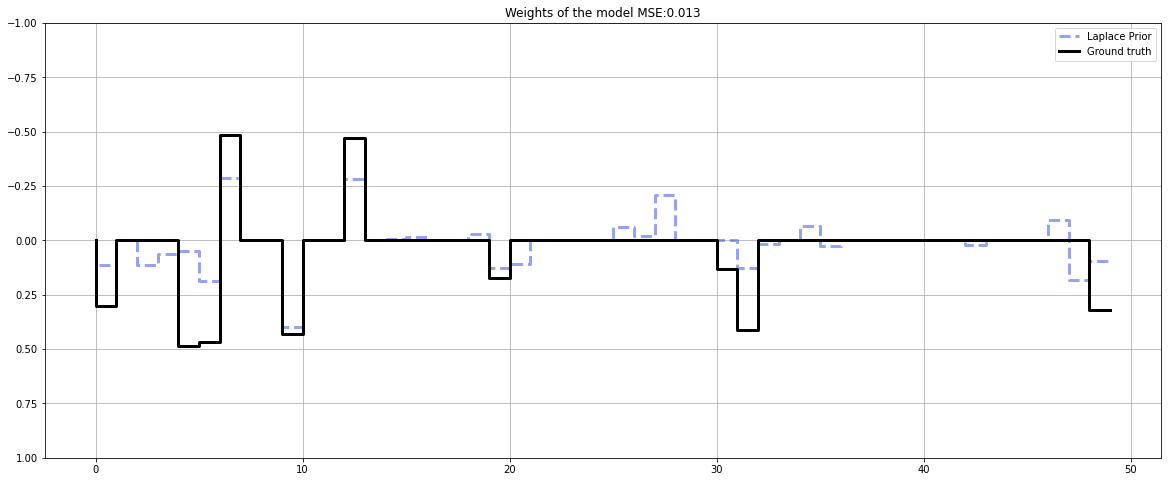

In [22]:
fit = sm.optimizing(data=input_data)
lp_stan_beta = fit['beta']

# beta_dist = np.quantile(lp_stan_beta, q=[0.05, 0.5, 0.95], axis=0 )
mse_values = mse(coefs, lp_stan_beta)
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model MSE:{:.3f}".format(mse_values))
plt.plot(idx, lp_stan_beta, color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Laplace Prior", alpha=0.5, linestyle='--')
# plt.fill_between(idx, beta_dist[0], beta_dist[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

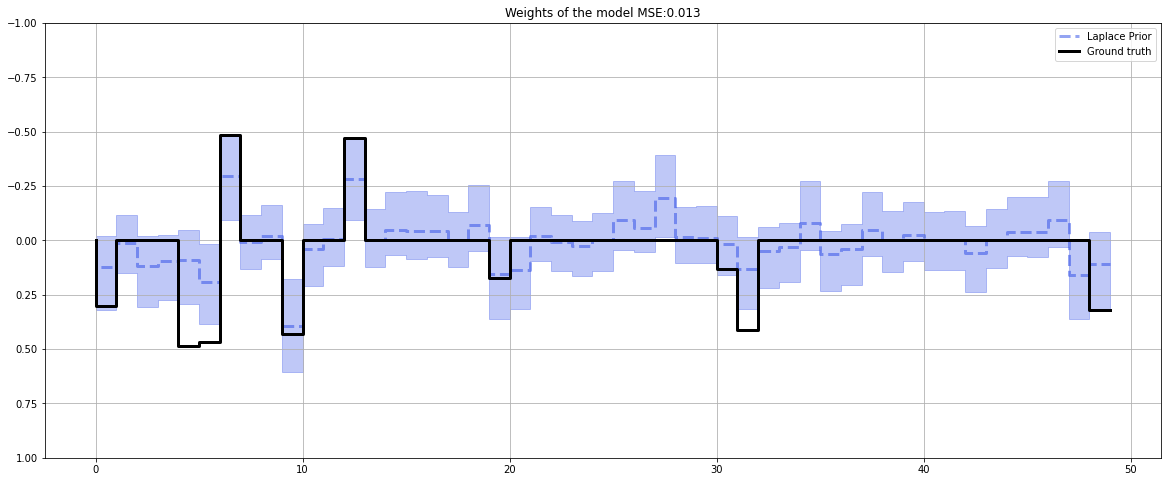

In [23]:
fit = sm.sampling(data=input_data, iter=1000, chains=4)
extract = fit.extract(permuted=True)
lp_stan_beta = extract['beta']
beta_dist = np.quantile(lp_stan_beta, q=[0.05, 0.5, 0.95], axis=0 )
mse_values = mse(coefs, beta_dist[1])
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model MSE:{:.3f}".format(mse_values))
plt.plot(idx, beta_dist[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Laplace Prior", alpha=0.5, linestyle='--')
plt.fill_between(idx, beta_dist[0], beta_dist[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

# Horseshoe Prior [Stan]

In [41]:
# see https://betanalpha.github.io/assets/case_studies/bayes_sparse_regression.html#37_comparison
hs_stan_code = """
    data {
      int<lower=1> N; // Number of data
      int<lower=1> P; // Number of covariates
      matrix[P, N] X;
      real y[N];
    }

    // slab_scale = 5, slab_df = 25 -> 8 divergences

    transformed data {
      real m0 = 10;           // Expected number of large slopes
      real slab_scale = 3;    // Scale for large slopes
      real slab_scale2 = square(slab_scale);
      real slab_df = 25;      // Effective degrees of freedom for large slopes
      real half_slab_df = 0.5 * slab_df;
    }

    parameters {
      vector[P] beta_tilde;
      vector<lower=0>[P] lambda;
      real<lower=0> c2_tilde;
      real<lower=0> tau_tilde;
      real alpha;
      real<lower=0> sigma;
    }

    transformed parameters {
      vector[P] beta;
      {
        real tau0 = (m0 / (P - m0)) * (sigma / sqrt(1.0 * N));
        real tau = tau0 * tau_tilde; // tau ~ cauchy(0, tau0)

        // c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
        // Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
        real c2 = slab_scale2 * c2_tilde;

        vector[P] lambda_tilde =
          sqrt( c2 * square(lambda) ./ (c2 + square(tau) * square(lambda)) );

        // beta ~ normal(0, tau * lambda_tilde)
        beta = tau * lambda_tilde .* beta_tilde;
      }
    }

    model {
      beta_tilde ~ normal(0, 1);
      lambda ~ cauchy(0, 1);
      tau_tilde ~ cauchy(0, 1);
      c2_tilde ~ inv_gamma(half_slab_df, half_slab_df);

      alpha ~ normal(0, 2);
      sigma ~ normal(0, 2);

      y ~ normal(X' * beta + alpha, sigma);
    }
"""
sm = pystan.StanModel(model_code=hs_stan_code)
with open('../models/hs_stan.pkl', 'wb') as f:
    pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f7c7fcb2648a34263464ddcb3e032f3 NOW.


In [73]:
sm = pickle.load(open('../models/hs_stan.pkl', 'rb'))

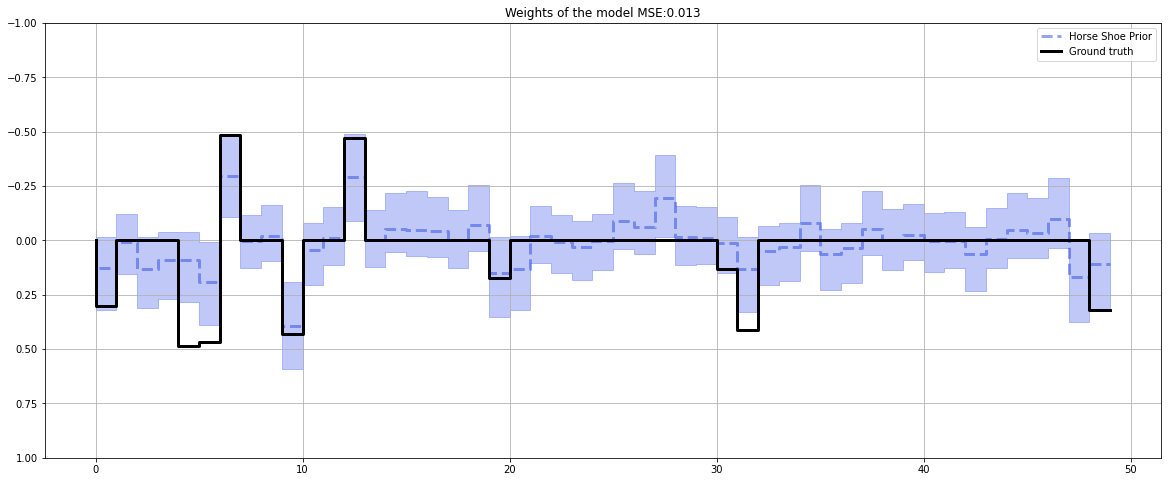

In [24]:
fit = sm.sampling(data=input_data, iter=1000, chains=4, control={'adapt_delta':0.99, 'max_treedepth':15})
extract = fit.extract(permuted=True)
hs_stan_beta = extract['beta']

beta_dist = np.quantile(hs_stan_beta, q=[0.05, 0.5, 0.95], axis=0 )
mse_values = mse(coefs, beta_dist[1])
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model MSE:{:.3f}".format(mse_values))
plt.plot(idx, beta_dist[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Horse Shoe Prior", alpha=0.5, linestyle='--')
plt.fill_between(idx, beta_dist[0], beta_dist[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

## Custom Horseshoe[Stan]

In [29]:
input_data.update({
    'LARGE_WEIGHT_SCALE': 1.0,
    'EXPECTED_SIZE': 15,
    'GLOBAL_SHRINKAGE_FACTOR': 1.0,
    'SLAB_DF': 25,
})

In [91]:
chs_stan_code = """
    data {
      int<lower=1> N; // Number of data
      int<lower=0> P; // Number of covariates
      matrix[P, N] X;
      real y[N];
      // horeshoe prior inputs
      real<lower=0> LARGE_WEIGHT_SCALE; 
      // Expected number of large weight
      real<lower=0, upper=P> EXPECTED_SIZE;
      // factor to tune down shrinkage power due to number of observations
      // in regular horseshoe, it should be 1, the smaller value, the smaller impact of horseshoe
      real<lower=1e-3, upper=1> GLOBAL_SHRINKAGE_FACTOR;
      real<lower=1> SLAB_DF;
    }
    
    transformed data {
      real sq_large_weight_scale = square(LARGE_WEIGHT_SCALE);
      real half_slab_df = 0.5 * SLAB_DF;
    }
    
    parameters {
      vector[P] beta_tilde;
      vector<lower=0>[P] lambda;
      real<lower=0> c2_tilde;
      real<lower=0> tau_tilde;
      real<lower=0> sigma;
    }

    transformed parameters {
      vector[P] beta;
      vector[N] yhat;
      {
        real tau0 = (EXPECTED_SIZE/ (P - EXPECTED_SIZE)) * (sigma / sqrt(1.0 * N * GLOBAL_SHRINKAGE_FACTOR));
        real tau = tau0 * tau_tilde; // tau ~ cauchy(0, tau0)

        // c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
        // Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
        real c2 = sq_large_weight_scale * c2_tilde;

        vector[P] lambda_tilde = sqrt(c2 * square(lambda) ./ (c2 + square(tau) * square(lambda)));

        // beta ~ normal(0, tau * lambda_tilde)
        beta = tau * lambda_tilde .* beta_tilde;
      }
      yhat = X' * beta;
    }
    
    model {
      beta_tilde ~ normal(0, 1);
      lambda ~ cauchy(0, 1);
      tau_tilde ~ cauchy(0, 1);
      c2_tilde ~ inv_gamma(half_slab_df, half_slab_df);
      sigma ~ normal(0, 2);
      y ~ normal(yhat, sigma);
    }
"""

sm = pystan.StanModel(model_code=chs_stan_code)
with open('../models/chs_stan.pkl', 'wb') as f:
    pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6d25d8c36c1f2830907b2c8b7ff8a93 NOW.


In [92]:
sm = pickle.load(open('../models/chs_stan.pkl', 'rb'))

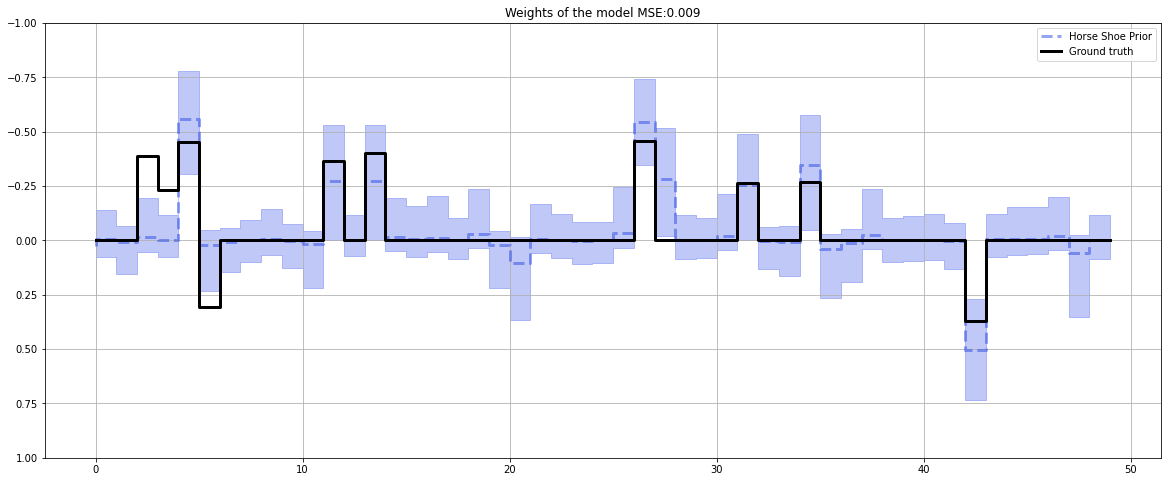

In [93]:
fit = sm.sampling(data=input_data, iter=1000, chains=4, control={'adapt_delta':0.99, 'max_treedepth':15})
extract = fit.extract(permuted=True)
hs_stan_beta = extract['beta']

beta_dist = np.quantile(hs_stan_beta, q=[0.05, 0.5, 0.95], axis=0 )
mse_values = mse(coefs, beta_dist[1])
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model MSE:{:.3f}".format(mse_values))
plt.plot(idx, beta_dist[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Horse Shoe Prior", alpha=0.5, linestyle='--')
plt.fill_between(idx, beta_dist[0], beta_dist[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

Note: originally, try this https://github.com/uber/orbit/blob/regression/orbit/stan/dlt.stan and it fits much slower than stan suggested HS prior

# Test in Pyro

In [ ]:
input_data.update({
    'LARGE_WEIGHT_SCALE': 1.0,
    'EXPECTED_SIZE': 15,
    'GLOBAL_SHRINKAGE_FACTOR': 1.0,
    'SLAB_DF': 25,
})

## Horse Shoe Prior [Pyro]

In [25]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoDelta
from pyro.optim import ClippedAdam
from orbit.estimators.pyro_estimator import PyroEstimator
torch.set_default_tensor_type('torch.DoubleTensor')

In [87]:
class HSRegressionModel:
    max_plate_nesting = 1  # max number of plates nested in model

    def __init__(self, data):
        for key, value in data.items():
            key = key.lower()
            if isinstance(value, (list, np.ndarray)):
                value = torch.tensor(value, dtype=torch.double)
            self.__dict__[key] = value

    def __call__(self):
        y = self.y
        x = self.x
        p = self.p
        n = self.n
        large_weight_scale = self.large_weight_scale
        expected_size = self.expected_size
        slab_df = self.slab_df
        extra_out = {}
        sq_large_weight_scale = large_weight_scale ** 2
        half_slab_df = 0.5 * slab_df
        
        sigma = pyro.sample("sigma", dist.HalfNormal(1))
        tau_tilde = pyro.sample("tau_tilde", dist.HalfCauchy(1))
            
        tau0 = (expected_size/ (p - expected_size)) * (sigma / (1.0 * n * 1.0) ** 0.5)
        tau = (tau0 * tau_tilde).unsqueeze(-1) # tau ~ cauchy(0, tau0)

        beta_tilde = pyro.sample("beta_tilde", dist.Normal(0, 1).expand([p]).to_event(1))
        lambda_ = pyro.sample("lambda_", dist.HalfCauchy(1).expand([p]).to_event(1))

        c2_tilde =  pyro.sample("c2_tilde", dist.InverseGamma(half_slab_df, half_slab_df))
   
        # c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
        # Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
        c2 = (sq_large_weight_scale * c2_tilde).unsqueeze(-1)
        lambda_tilde = c2 * lambda_ ** 2 / (c2 + torch.square(tau) * lambda_ ** 2).sqrt()

        beta = tau * lambda_tilde * beta_tilde
        yhat = beta @ x;
        with pyro.plate("response_plate", n):
            pyro.sample("response", dist.Normal(yhat, sigma), obs=y)

        extra_out.update({'beta': beta, 'yhat':yhat})
        
        return extra_out

In [88]:
verbose = True
message = 100
num_sample = 1000
num_steps = 1001

In [89]:
model = HSRegressionModel(input_data)  # concrete

# Perform stochastic variational inference using an auto guide.
pyro.clear_param_store()
# guide = AutoLowRankMultivariateNormal(model)
# only if you use AutoLowRankMultivariateNormal
# elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)

guide = AutoDelta(model)
elbo = Trace_ELBO()

optim = ClippedAdam({"lr": 0.1})
svi = SVI(model, guide, optim, elbo)
verbose = True
message = 100
for step in range(num_steps):
    loss = svi.step()
    if verbose and step % message == 0:
        # only if you use AutoLowRankMultivariateNormal
#         scale_rms = guide._loc_scale()[1].detach().pow(2).mean().sqrt().item()
        scale_rms = 0
        print("step {: >4d} loss = {:0.5g}, scale = {:0.5g}".format(step, loss, scale_rms))

step    0 loss = 569.73, scale = 0
step  100 loss = 506.12, scale = 0
step  200 loss = 505.98, scale = 0
step  300 loss = 505.94, scale = 0
step  400 loss = 505.91, scale = 0
step  500 loss = 505.9, scale = 0
step  600 loss = 505.9, scale = 0
step  700 loss = 505.89, scale = 0
step  800 loss = 505.89, scale = 0
step  900 loss = 505.88, scale = 0
step 1000 loss = 505.89, scale = 0


In [90]:
# Extract samples.
vectorize = pyro.plate("samples", num_sample, dim=-1 - model.max_plate_nesting)

with pyro.poutine.trace() as tr:
    samples = vectorize(guide)()
with pyro.poutine.replay(trace=tr.trace):
    samples.update(vectorize(model)())
    
# Convert from torch.Tensors to numpy.ndarrays.
extract = {
    name: value.detach().squeeze().numpy()
    for name, value in samples.items()
}
lp_pyro_beta = extract['beta']

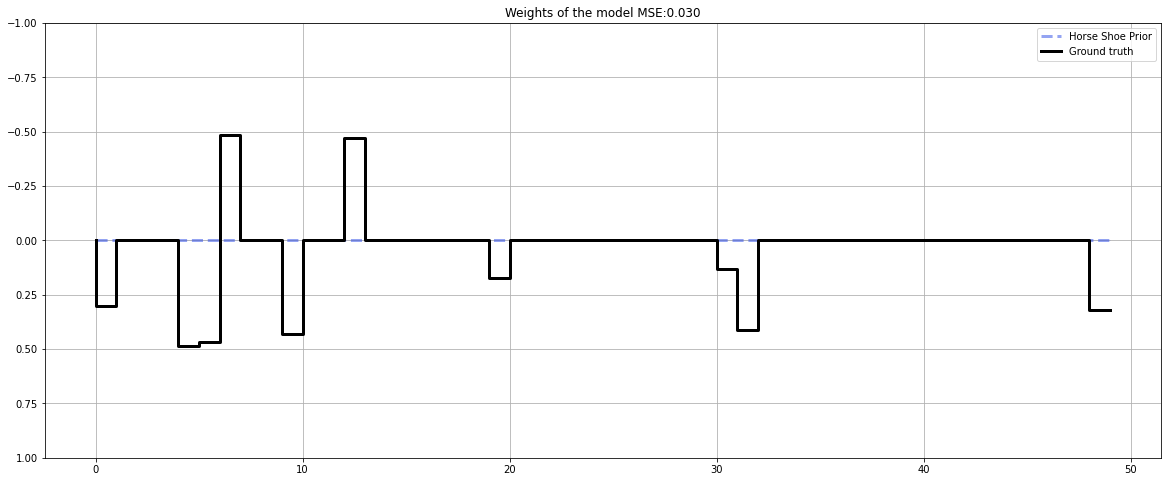

In [91]:
beta_dist = np.quantile(lp_pyro_beta, q=[0.05, 0.5, 0.95], axis=0 )
mse_values = mse(coefs, beta_dist[1])
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model MSE:{:.3f}".format(mse_values))
plt.plot(idx, beta_dist[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Horse Shoe Prior", alpha=0.5, linestyle='--')
plt.fill_between(idx, beta_dist[0], beta_dist[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

## Laplace Prior [Pyro]

In [72]:
class LassoRegressionModel:
    max_plate_nesting = 1  # max number of plates nested in model

    def __init__(self, data):
        for key, value in data.items():
            key = key.lower()
            if isinstance(value, (list, np.ndarray)):
                value = torch.tensor(value, dtype=torch.double)
            self.__dict__[key] = value


    def __call__(self):
        y = self.y
        x = self.x
        p = self.p
        n = self.n
        extra_out = {}
        
#         alpha = pyro.sample("alpha", dist.LogNormal(torch.zeros(1), 1).to_event(1))
        beta = pyro.sample("beta", dist.Laplace(torch.zeros(p), 1).to_event(1))
        sigma = pyro.sample("sigma", dist.HalfNormal(1))

        yhat = beta @ x;
        with pyro.plate("response_plate", n):
            pyro.sample("response", dist.Normal(yhat, sigma), obs=y)

        extra_out.update({'yhat':yhat})
        
        return extra_out

In [73]:
# class PyroEstimatorVI(PyroEstimator):
#     """Pyro Estimator for VI Sampling

#     Parameters
#     ----------
#     num_sample : int
#         Number of samples ot draw for inference, default 100
#     num_particles : int
#         Number of particles used in :class: `~pyro.infer.Trace_ELBO` for SVI optimization
#     kwargs
#         Additional `PyroEstimator` class args

#     """

#     def __init__(self, num_sample=100, num_particles=100, **kwargs):
#         super().__init__(**kwargs)
#         self.num_sample = num_sample
#         self.num_particles = num_particles

#     def fit(self, model, data_input, init_values=None):
#         # verbose is passed through from orbit.models.base_estimator
#         verbose = self.verbose
#         message = self.message
#         learning_rate = self.learning_rate
#         learning_rate_total_decay = self.learning_rate_total_decay
#         num_sample = self.num_sample
#         seed = self.seed
#         num_steps = self.num_steps

#         pyro.set_rng_seed(seed)
#         _model = model(data_input)  # concrete

#         # Perform stochastic variational inference using an auto guide.
#         pyro.clear_param_store()
#         guide = AutoLowRankMultivariateNormal(_model)
#         optim = ClippedAdam({
#             "lr": learning_rate,
#             "lrd": learning_rate_total_decay ** (1 / num_steps)
#         })
#         elbo = Trace_ELBO(num_particles=self.num_particles, vectorize_particles=True)
#         svi = SVI(model, guide, optim, elbo)

#         for step in range(num_steps):
#             loss = svi.step()
#             if verbose and step % message == 0:
#                 scale_rms = guide._loc_scale()[1].detach().pow(2).mean().sqrt().item()
#                 print("step {: >4d} loss = {:0.5g}, scale = {:0.5g}".format(step, loss, scale_rms))

#         # Extract samples.
#         vectorize = pyro.plate("samples", num_sample, dim=-1 - model.max_plate_nesting)
#         with pyro.poutine.trace() as tr:
#             samples = vectorize(guide)()
#         with pyro.poutine.replay(trace=tr.trace):
#             samples.update(vectorize(model)())

#         # Convert from torch.Tensors to numpy.ndarrays.
#         extract = {
#             name: value.detach().squeeze().numpy()
#             for name, value in samples.items()
#         }

# #         # make sure that model param names are a subset of stan extract keys
# #         invalid_model_param = set(model_param_names) - set(list(extract.keys()))
# #         if invalid_model_param:
# #             raise EstimatorException("Pyro model definition does not contain required parameters")

# #         # `stan.optimizing` automatically returns all defined parameters
# #         # filter out unnecessary keys
# #         extract = {param: extract[param] for param in model_param_names}

#         return extract

# pyro_estimator = PyroEstimatorVI(learning_rate=0.1)
# pyro_estimator.fit(model=RegressionModel, data_input=input_data)

In [74]:
verbose = True
message = 100
num_sample = 1000
num_steps = 1001

In [75]:
model = LassoRegressionModel(input_data)  # concrete

# Perform stochastic variational inference using an auto guide.
pyro.clear_param_store()
# guide = AutoLowRankMultivariateNormal(model)
guide = AutoDelta(model)
optim = ClippedAdam({"lr": 0.1})
# only if you use AutoLowRankMultivariateNormal
# elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
elbo = Trace_ELBO()
svi = SVI(model, guide, optim, elbo)
verbose = True
message = 100
for step in range(num_steps):
    loss = svi.step()
    if verbose and step % message == 0:
        # only if you use AutoLowRankMultivariateNormal
#         scale_rms = guide._loc_scale()[1].detach().pow(2).mean().sqrt().item()
        scale_rms = 0
        print("step {: >4d} loss = {:0.5g}, scale = {:0.5g}".format(step, loss, scale_rms))

step    0 loss = 738.46, scale = 0
step  100 loss = 413.49, scale = 0
step  200 loss = 413.5, scale = 0
step  300 loss = 413.62, scale = 0
step  400 loss = 413.75, scale = 0
step  500 loss = 413.76, scale = 0
step  600 loss = 413.79, scale = 0
step  700 loss = 413.9, scale = 0
step  800 loss = 413.78, scale = 0
step  900 loss = 413.6, scale = 0
step 1000 loss = 414.12, scale = 0


In [76]:
# Extract samples.
vectorize = pyro.plate("samples", num_sample, dim=-1 - model.max_plate_nesting)

with pyro.poutine.trace() as tr:
    samples = vectorize(guide)()
with pyro.poutine.replay(trace=tr.trace):
    samples.update(vectorize(model)())
    
# Convert from torch.Tensors to numpy.ndarrays.
extract = {
    name: value.detach().squeeze().numpy()
    for name, value in samples.items()
}
lp_pyro_beta = extract['beta']

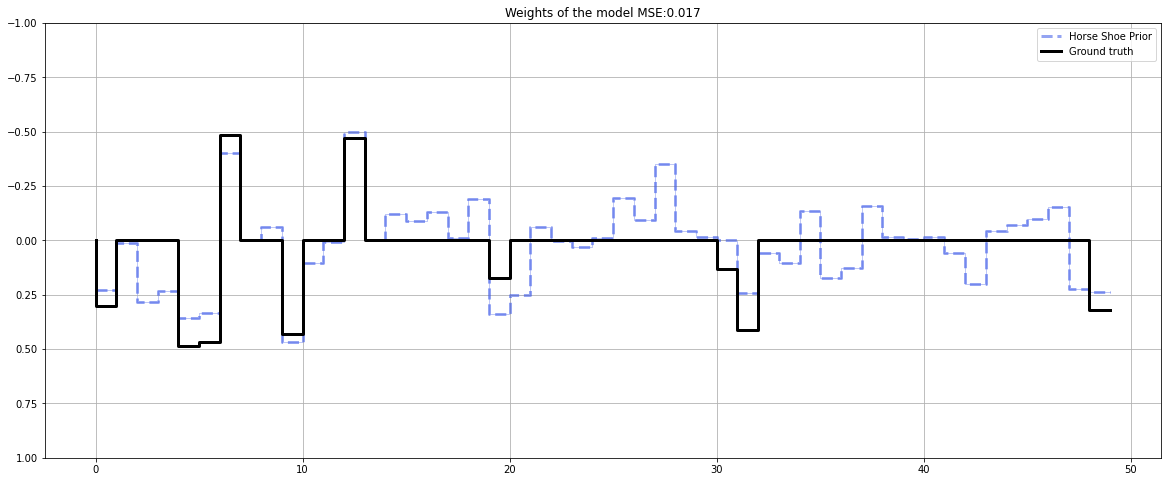

In [77]:
beta_dist = np.quantile(lp_pyro_beta, q=[0.05, 0.5, 0.95], axis=0 )
mse_values = mse(coefs, beta_dist[1])
lw=3
idx = np.arange(NUM_OF_REGRESSORS)
plt.figure(figsize=(20, 8))
plt.title("Weights of the model MSE:{:.3f}".format(mse_values))
plt.plot(idx, beta_dist[1], color=QualitativePalette.Line4.value[2], linewidth=lw,  drawstyle='steps', label="Horse Shoe Prior", alpha=0.5, linestyle='--')
plt.fill_between(idx, beta_dist[0], beta_dist[2], step='pre', alpha=0.3, color=QualitativePalette.Line4.value[2])
plt.plot(coefs, color="black", linewidth=lw,  drawstyle='steps', label="Ground truth")
plt.ylim(1, -1)
plt.legend()
plt.grid()

In [37]:
yhat =  extract['yhat']

In [38]:
yhat_mean = np.mean(yhat, axis=0)

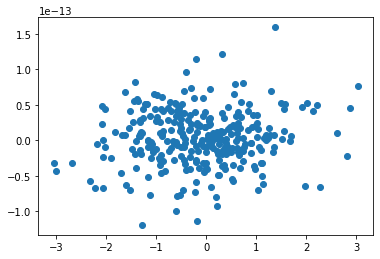

In [39]:
plt.scatter(y, yhat_mean)